In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from path_explain.path_explainer_tf import PathExplainerTF
from path_explain.utils import set_up_environment
from plot.scatter import scatter_plot
from plot.summary import summary_plot

from preprocess import heart_dataset

In [3]:
set_up_environment(visible_devices='0')

In [4]:
x_train, y_train, x_test, y_test, feature_names = heart_dataset()

In [7]:
x_train.shape

(242, 22)

In [8]:
x_test.shape

(61, 22)

In [10]:
y_train.sum()

131

In [3]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(22,)))
model.add(tf.keras.layers.Dense(units=128, activation=tf.keras.activations.softplus))
model.add(tf.keras.layers.Dense(units=64, activation=tf.keras.activations.softplus))
model.add(tf.keras.layers.Dense(units=1,  activation=None))
model.add(tf.keras.layers.Activation(tf.keras.activations.sigmoid))

learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.1,
                                                               decay_steps=1,
                                                               decay_rate=0.99,
                                                               staircase=True)
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)
loss = tf.keras.losses.BinaryCrossentropy()
metrics = [tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.AUC()]
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)
model.fit(x_train, y_train, batch_size=242, epochs=300, verbose=0)
train_loss, train_accuracy, train_auc = model.evaluate(x_train, y_train, batch_size=51, verbose=0)
test_loss, test_accuracy, test_auc = model.evaluate(x_test, y_test, batch_size=51, verbose=0)

In [4]:
print('Train loss: {:.4f}\tTrain Accuracy: {:.4f}\tTrain AUC: {:.4f}'.format(train_loss, train_accuracy, train_auc))
print('Test loss: {:.4f}\tTest Accuracy: {:.4f}\tTest AUC: {:.4f}'.format(test_loss, test_accuracy, test_auc))

Train loss: 0.2273	Train Accuracy: 0.9174	Train AUC: 0.9697
Test loss: 0.3384	Test Accuracy: 0.9016	Test AUC: 0.9276


In [5]:
explainer = PathExplainerTF(model)

In [54]:
all_data = np.concatenate([x_train, x_test], axis=0)

In [60]:
attributions = explainer.attributions(inputs=all_data,
                                      baseline=x_train,
                                      batch_size=100,
                                      num_samples=200,
                                      use_expectation=True,
                                      output_indices=0,
                                      verbose=True)

100%|██████████| 303/303 [00:01<00:00, 152.11it/s]


In [61]:
interactions = explainer.interactions(inputs=all_data,
                                      baseline=x_train,
                                      batch_size=100,
                                      num_samples=200,
                                      use_expectation=True,
                                      output_indices=0,
                                      verbose=True)

100%|██████████| 303/303 [03:04<00:00,  1.65it/s]


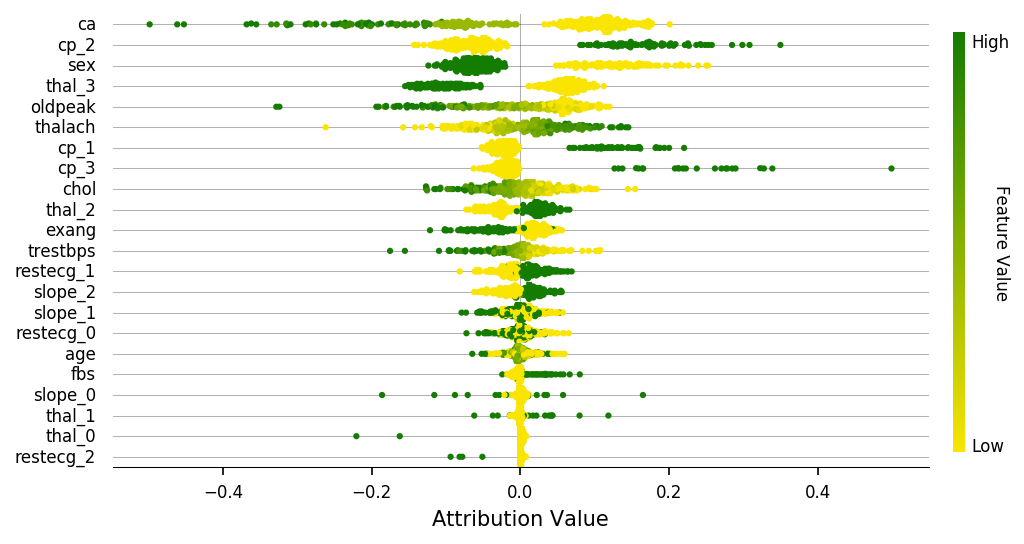

In [62]:
summary_plot(attributions,
             all_data,
             interactions=None,
             interaction_feature=None,
             feature_names=feature_names,
             plot_top_k=22)

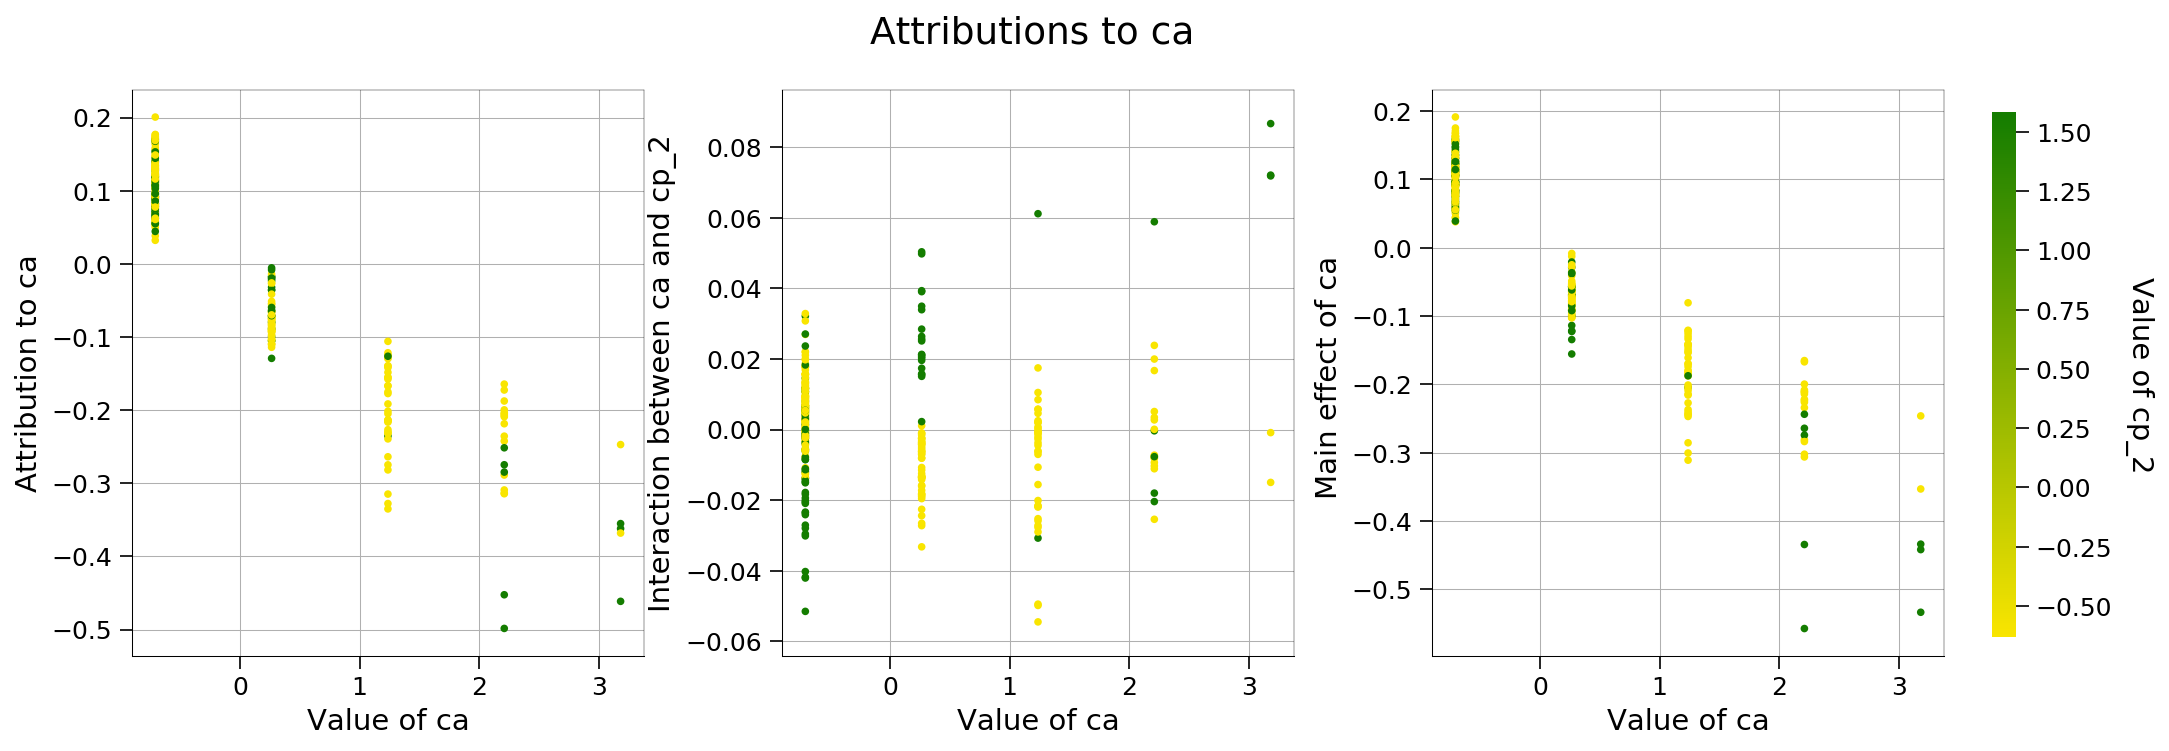

In [63]:
fig, axs = scatter_plot(attributions,
                        all_data,
                        feature_index='ca',
                        interactions=interactions,
                        color_by='cp_2',
                        feature_names=feature_names,
                        scale_y_ind=True)

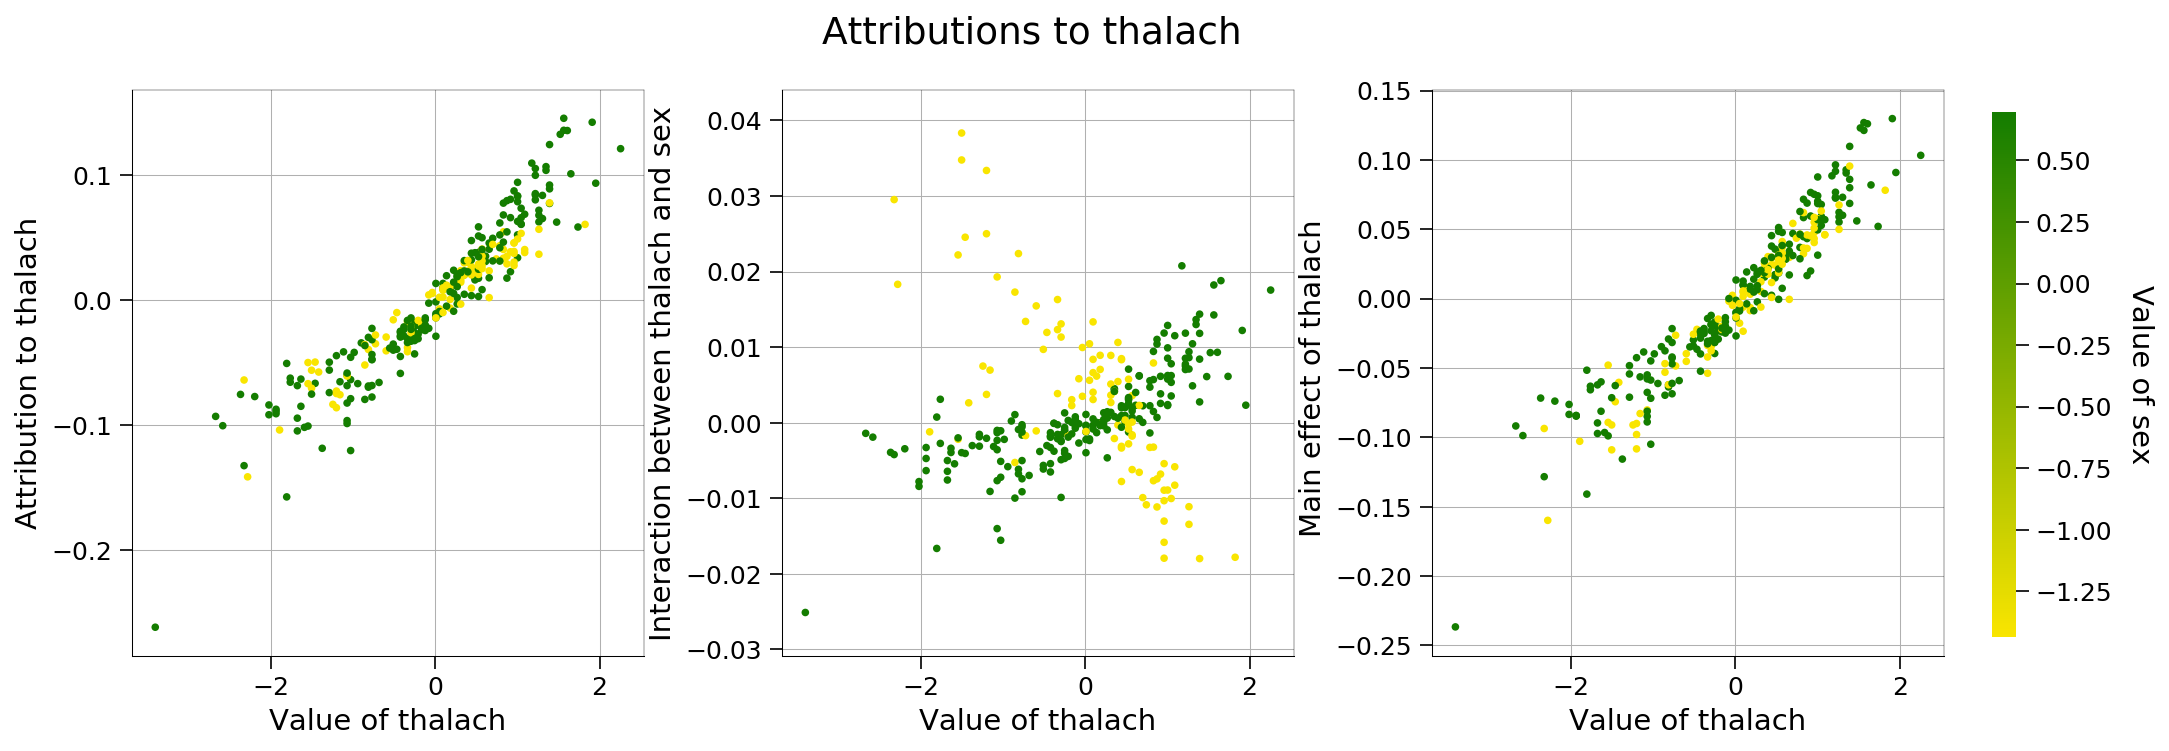

In [64]:
fig, axs = scatter_plot(attributions,
                        all_data,
                        feature_index='thalach',
                        interactions=interactions,
                        color_by='sex',
                        feature_names=feature_names,
                        scale_y_ind=True)

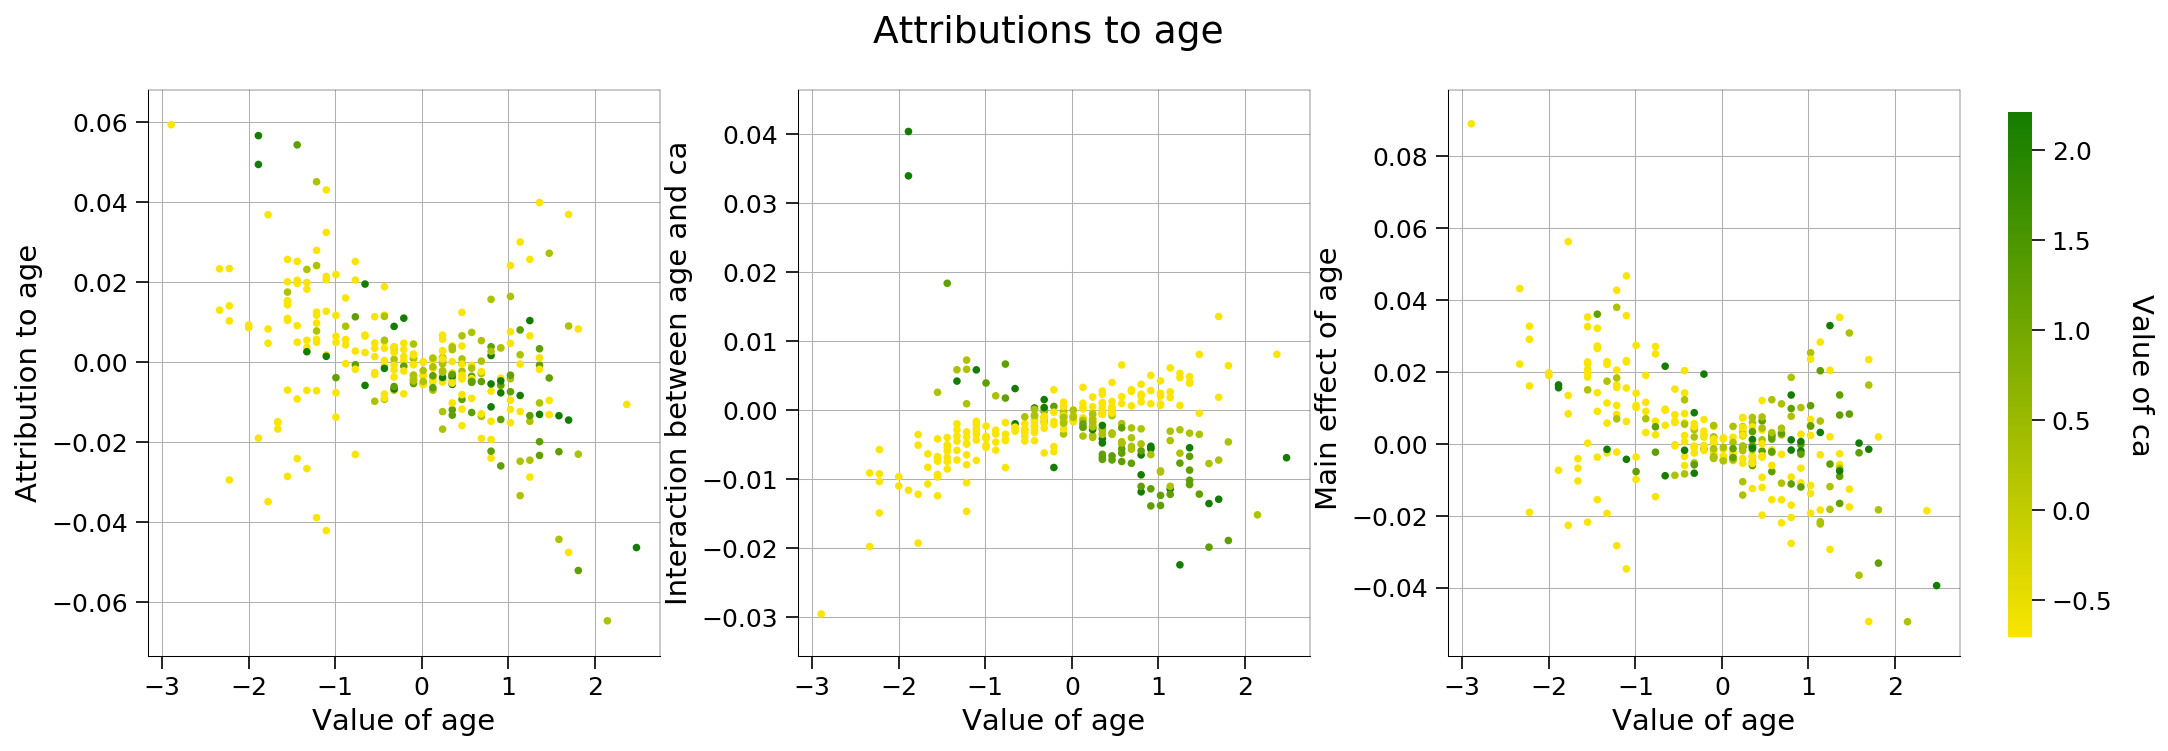

In [65]:
fig, axs = scatter_plot(attributions,
                        all_data,
                        feature_index='age',
                        interactions=interactions,
                        color_by='ca',
                        feature_names=feature_names,
                        scale_y_ind=True)